# **0. Dependencies**

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

!pip install pycountry_convert 
import pycountry_convert as pc
import pandas as pd
from scipy.ndimage.interpolation import shift
import copy
import scipy.stats as stats

# plt.style.use('fivethirtyeight')
%matplotlib inline

# **1. SIRD Model**

The COVID-19 infectious disease is an epidemic. To model an epidemic, suitable groups (also known as compartments) are defined to cover the entire population of a country. The population **N** is assumed to be constant because:
+ The epidemic has a (relatively) short time scale, for which the new births can be neglected.
+ The number of deaths is small as compared with the entire population
+ Travel restrictions are enforced.

The population N is divided into mutually exclusive groups: susceptible (**S**), infected (**I**), deceased (**D**), and recovered (**R**) as below:
```

+-------------+        +----------+        +-----------+
| Susceptible | -----> | Infected | -----> | Recovered |
+-------------+        +----------+        +-----------+
       S                  I   |                  R
                              |
                              |    +----------+
                              +--> | Deceased |
                                   +----------+
                                         D
```

In this model, the deaths are due to COVID-19. Every group is assumed to have the same characteristics, i.e., the groups are homogeneous. Every susceptible person can contract the virus (the immune group is neglected). Mathematically, the population N, which does not vary in time, is the sum of the groups S, I, R, D, which vary in time.
```
N = S + R + I + D
```
With the assumptions, SIRD model are expressed by four ordinary differential equations (ODEs) with time-varying parameters (non-autonomous dynamical system)
```
dS/dt = -β*(I/N)*S
dI/dt = β*(I/N)*S - (γ+μ)*I
dR/dt = γ*I
dD/dt = μ*I
```
subject to initial conditions `S0`, `I0`, `R0`, `D0`. In compact form,
```
dq/dt = F(q, alpha)
q = q0 at t=0
```
Where `F` is the model (i.e., the SIRD equations), and `q` and `alpha` are the column vectors of the state and parameters, respectively.
```
q: [S; I; R; D]
alpha: [β; γ; μ]
```
I/N is the probability to come into contact with an infected individual; β is the average number of contacts per person per unit of time weighed by the transmissibility (contact rate); γ is the average number of recovered people per unit of time (recovery rate); μ is the average number of deaths due to COVID-19 per unit of time (death rate). The basic reproduction ratio1, R0=β/γ, is the expected number of secondary infections from a single infection entering a population where all members are susceptible. If R0 > 1, the number of infected increases. If R0 < 1, the disease does not grow on average.


In [3]:
def runSIRModel(country, population, num_last_days, num_future_days,
                param_filter=(0.6, 0.4), param_order=3):
  def data_spilt(data, orders, start):
      x_train = np.empty((len(data) - start - orders, orders))
      y_train = data[start + orders:]

      for i in range(len(data) - start - orders):
          x_train[i] = data[i + start:start + orders + i]

      return x_train, y_train


  def ridge(x, y):
      print('\nStart searching good parameters for the task...')
      parameters = {'alpha': np.arange(0, 0.100005, 0.000005).tolist(),
                    "tol": [1e-8],
                    'fit_intercept': [True, False],
                    'normalize': [True, False]}

      clf = GridSearchCV(Ridge(), parameters, n_jobs=-1, cv=5)
      clf.fit(x, y)

      print('\nResults for the parameters grid search:')
      print('Model:', clf.best_estimator_)
      print('Score:', clf.best_score_)

      return clf


  ########## data ##########
  try:
    X_cml = getDataFromCountry(df_confirmed, country)[0][-num_last_days:]
    recovered = getDataFromCountry(df_recovered, country)[0][-num_last_days:]
    death = getDataFromCountry(df_deaths, country)[0][-num_last_days:]
  except:
    X_cml = getDataFromContinent(df_confirmed, country)[0][-num_last_days:]
    recovered = getDataFromContinent(df_recovered, country)[0][-num_last_days:]
    death = getDataFromContinent(df_deaths, country)[0][-num_last_days:]

  ########## data preprocess ##########
  X = X_cml - recovered - death
  R = recovered + death

  for i in range(1, R.shape[0]):
    if R[i] < R[i-1]: R[i] = R[i-1]

  n = np.array([population] * len(X), dtype=np.float64)

  S = n - X - R

  X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
  R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T

  gamma = (R[1:] - R[:-1]) / X[:-1]
  beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))

  for i in range(2, gamma.shape[0]):
    gamma[i] = param_filter[0]*gamma[i] + param_filter[1]*gamma[i-1]
    beta[i] = param_filter[0]*beta[i] + param_filter[1]*beta[i-1]


  R0 = beta / gamma

  ########## Parameters for Ridge Regression ##########
  ##### Orders of the two FIR filters in (12), (13) in the paper. #####
  orders_beta = param_order
  orders_gamma = param_order

  ##### Select a starting day for the data training in the ridge regression. #####
  start_beta = 5
  start_gamma = 5

  ########## Print Info ##########
  print("\nThe latest transmission rate beta of SIR model:", beta[-1])
  print("The latest recovering rate gamma of SIR model:", gamma[-1])
  print("The latest basic reproduction number R0:", R0[-1])

  ########## Ridge Regression ##########
  ##### Split the data to the training set and testing set #####
  x_beta, y_beta = data_spilt(beta, orders_beta, start_beta)
  x_gamma, y_gamma = data_spilt(gamma, orders_gamma, start_gamma)

  ##### Searching good parameters #####
  # clf_beta = ridge(x_beta, y_beta)
  # clf_gamma = ridge(x_gamma, y_gamma)

  ##### Training and Testing #####
  clf_beta = Ridge(alpha=0.003765, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
  clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None,normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)

  beta_hat = clf_beta.predict(x_beta)
  gamma_hat = clf_gamma.predict(x_gamma)

  ########## Time-dependent SIR model ##########

  ##### Parameters for the Time-dependent SIR model #####
  stop_X = 0 # stopping criteria
  stop_day = num_future_days

  day_count = 0
  turning_point = 0

  S_predict = [S[-1]]
  X_predict = [X[-1]]
  R_predict = [R[-1]]

  predict_beta = np.array(beta[-orders_beta:]).tolist()
  predict_gamma = np.array(gamma[-orders_gamma:]).tolist()
  while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
      if predict_beta[-1] > predict_gamma[-1]:
          turning_point += 1

      next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
      next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

      if next_beta < 0:
          next_beta = 0
      if next_gamma < 0:
          next_gamma = 0

      predict_beta.append(next_beta)
      predict_gamma.append(next_gamma)

      next_S = ((-predict_beta[-1] * S_predict[-1] *
                X_predict[-1]) / n[-1]) + S_predict[-1]
      next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
                n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
      next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

      S_predict.append(next_S)
      X_predict.append(next_X)
      R_predict.append(next_R)

      day_count += 1

  ########## Print Info ##########
  print('\nConfirmed cases tomorrow:', np.rint(X_predict[1] + R_predict[1]))
  print('Infected persons tomorrow:', np.rint(X_predict[1]))
  print('Recovered + Death persons tomorrow:', np.rint(R_predict[1]))

  print('\nEnd day:', day_count)
  print('Confirmed cases on the end day:', np.rint(X_predict[-2] + R_predict[-2]))

  print('\nTuring point:', turning_point)

  ########## Plot the time evolution of the time-dependent SIR model ##########
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 10))

  ax[0,0].plot(range(start_beta+orders_beta+1, start_beta+orders_beta+1+len(y_beta)), y_beta, label=r'$\beta (t)$')
  ax[0,0].plot(range(start_beta+orders_beta+1, start_beta+orders_beta+1+len(y_beta)), beta_hat, label=r'$\hat{\beta}(t)$')
  ax[0,0].plot(range(start_beta+orders_beta+len(y_beta)-2, start_beta+orders_beta+len(y_beta)-2+len(predict_beta)), predict_beta, label=r'$\hat{\beta}(t) future$')
  ax[0,0].legend()
  ax[0,0].set_xlim(left=0)
  ax[0,0].set_title("beta")

  ax[0,1].plot(range(start_gamma+orders_gamma+1, start_gamma+orders_gamma+1+len(y_gamma)), y_gamma, label=r'$\gamma (t)$')
  ax[0,1].plot(range(start_gamma+orders_gamma+1, start_gamma+orders_gamma+1+len(y_gamma)), gamma_hat, label=r'$\hat{\gamma}(t)$')
  ax[0,1].plot(range(start_gamma+orders_gamma+len(y_gamma)-2, start_gamma+orders_gamma+len(y_gamma)-2+len(predict_gamma)), predict_gamma, label=r'$\hat{\gamma}(t) future$')
  ax[0,1].legend()
  ax[0,1].set_title("gamma")

  ax[1,0].plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, '--', label=r'$\hat{X}(t)$', color='darkorange')
  ax[1,0].plot(range(len(X)), X, '-', label=r'$X(t)$', color='chocolate')
  ax[1,0].legend()
  ax[1,0].set_title("Active Infected People")

  ax[1,1].plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), R_predict, '--', label=r'$\hat{R}(t)$', color='limegreen')
  ax[1,1].plot(range(len(X)), R, '-', label=r'$R(t)$', color='darkgreen')
  ax[1,1].legend()
  ax[1,1].set_title("Recovery + Death People")

  plt.show()

# **2. Prepare Data**

In [4]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# Preprocessing
df_confirmed = df_confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1)
df_confirmed.index = df_confirmed['Country/Region']
df_confirmed = df_confirmed.drop(['Country/Region'], axis=1).groupby('Country/Region').sum()

df_deaths = df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1)
df_deaths.index = df_deaths['Country/Region']
df_deaths = df_deaths.drop(['Country/Region'], axis=1).groupby('Country/Region').sum()

df_recovered = df_recovered.drop(['Province/State', 'Lat', 'Long'], axis=1)
df_recovered.index = df_recovered['Country/Region']
df_recovered = df_recovered.drop(['Country/Region'], axis=1).groupby('Country/Region').sum()

def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe',
    'na': 'Others'
}

df_confirmed.insert(0, "continent", [continents[country_to_continent_code(country)] for country in df_confirmed.index])
df_deaths.insert(0, "continent", [continents[country_to_continent_code(country)] for country in df_deaths.index])
df_recovered.insert(0, "continent", [continents[country_to_continent_code(country)] for country in df_recovered.index])

def getDataFromCountry(df, nameCountry, fromTime="1/22/20", toTime="8/25/20"):
  days = df_confirmed.keys()
  for i, day in enumerate(days):
    if day == fromTime:
      indexFrom = i
    if day == toTime:
      indexTo = i
      break
  return df.loc[[nameCountry], :].iloc[:, indexFrom:indexTo].to_numpy().flatten(), list(days[indexFrom: indexTo])

def getDataFromContinent(df, continent, fromTime="1/22/20", toTime="8/25/20"):
  tmp = df.groupby("continent").sum()
  for i, day in enumerate(tmp.keys()):
    if day == fromTime:
      indexFrom = i
    if day == toTime:
      indexTo = i
      break
  return tmp.loc[[continent], :].iloc[:, indexFrom:indexTo].to_numpy().flatten(), list(tmp.keys()[indexFrom: indexTo])

def getDataAll(df):
  tmp = df.drop(['continent'], axis=1).sum(axis=0)
  return tmp.values, tmp.index.to_numpy()

def getNewCaseAll(df):
  tmp, days = getDataAll(df)
  tmp = tmp - shift(tmp, 1)
  tmp[tmp < 0] = 0
  return tmp, days

def getNewCaseFormCountry(df, nameCountry, fromTime="1/22/20", toTime="8/25/20"):
  tmp, days = getDataFromCountry(df, nameCountry, fromTime, toTime)
  tmp = tmp - shift(tmp, 1)
  tmp[tmp < 0] = 0
  return tmp, days

def getNewCaseFormContient(df, nameCountry, fromTime="1/22/20", toTime="8/25/20"):
  tmp, days = getDataFromContinent(df, nameCountry, fromTime, toTime)
  tmp = tmp - shift(tmp, 1)
  tmp[tmp < 0] = 0
  return tmp, days
def getAveragedNewCaseFormCountry(df, nameCountry, fromTime="1/22/20", toTime="8/25/20"):
  tmp, days = getNewCaseFormCountry(df, nameCountry, fromTime, toTime)
  for i in range(0, len(tmp)):
    min_ = i if i <= 3 else i - 3
    max_ = len(tmp) if i >= len(tmp) else i + 4
    tmp[i] = np.sum(tmp[min_ : max_])/len(tmp[min_ : max_])
  return tmp, days

def getAveraged7Days(data):
  tmp = copy.deepcopy(data)
  for i in range(0, len(tmp)):
    min_ = i if i <= 3 else i - 3
    max_ = len(tmp) if i >= len(tmp) else i + 4
    tmp[i] = np.sum(tmp[min_ : max_])/len(tmp[min_ : max_])
  return tmp
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def exponential(x, lam):
  return lam*np.exp(-np.power(x, lam))

# print(getDataAll(df_confirmed))
# print(getDataFromCountry(df_confirmed, "Brazil"))
# print(getDataFromContinent(df_confirmed, "Asia"))

# **3. Visualize Data**

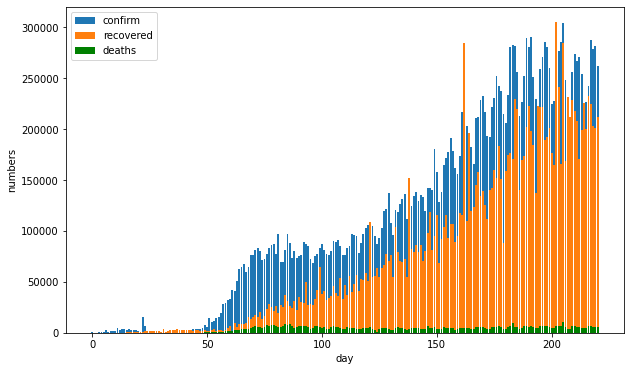

In [5]:
world_data = [getNewCaseAll(df_confirmed), getNewCaseAll(df_deaths), getNewCaseAll(df_recovered)]
days = world_data[0][1]
x_ = np.linspace(0, len(days) - 1, len(days))

plt.figure(figsize = (10, 6))
plt.bar(x_, world_data[0][0], label='confirm')
plt.bar(x_, world_data[2][0], label='recovered')
plt.bar(x_, world_data[1][0], label='deaths', color='green')
plt.xlabel('day')
plt.ylabel('numbers')
# plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

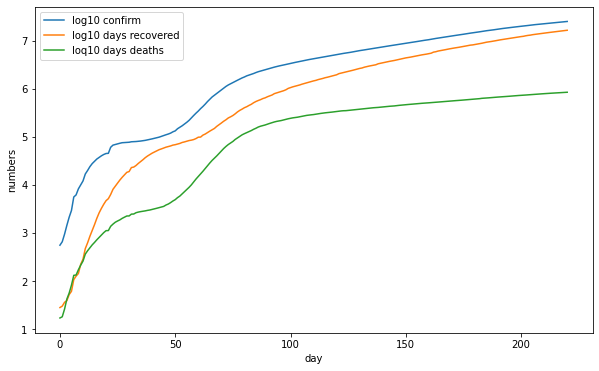

In [6]:
world_data = [getDataAll(df_confirmed), getDataAll(df_deaths), getDataAll(df_recovered)]
plt.figure(figsize = (10, 6))
plt.plot(x_, np.log10(world_data[0][0]), label='log10 confirm')
plt.plot(x_, np.log10(world_data[2][0]), label='log10 days recovered')
plt.plot(x_, np.log10(world_data[1][0]), label='loq10 days deaths')
plt.xlabel('day')
plt.ylabel('numbers')
# plt.title("")
# plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

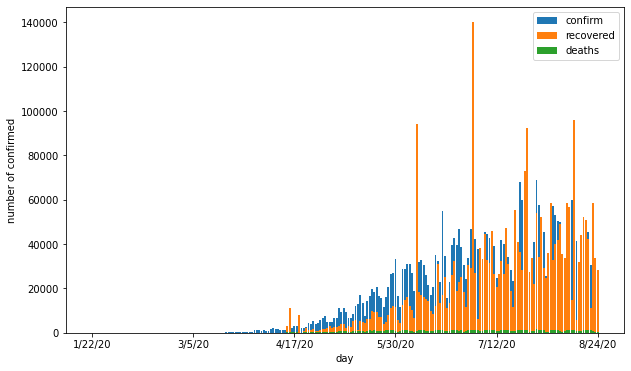

In [7]:

brazil_data = [getNewCaseFormCountry(df_confirmed, 'Brazil'), getNewCaseFormCountry(df_deaths, 'Brazil'), getNewCaseFormCountry(df_recovered, 'Brazil')]
days = brazil_data[0][1]
x_brazil = np.linspace(0, len(days) - 1, len(days))

plt.figure(figsize = (10, 6))
plt.bar(x_brazil, brazil_data[0][0], label='confirm')
plt.bar(x_brazil, brazil_data[2][0], label='recovered')
plt.bar(x_brazil, brazil_data[1][0], label='deaths')
plt.xlabel('day')
plt.ylabel('number of confirmed')
plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

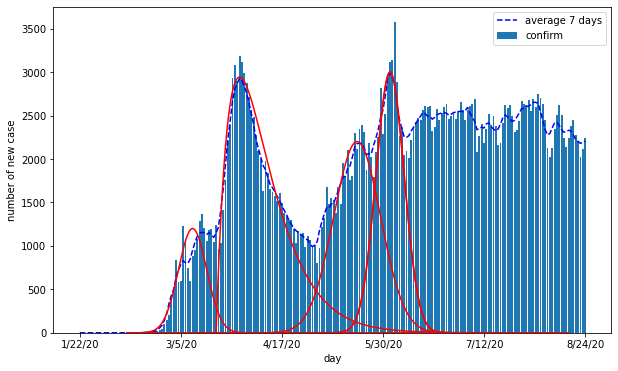

In [8]:

ir_data = [getNewCaseFormCountry(df_confirmed, 'Iran'), getNewCaseFormCountry(df_deaths, 'Iran'), getNewCaseFormCountry(df_recovered, 'Iran')]
days = ir_data[0][1]
x_ir = np.linspace(0, len(days) - 1, len(days))
ir_avg = getAveraged7Days(ir_data[0][0])


plt.figure(figsize = (10, 6))
plt.bar(x_ir, ir_data[0][0], label='confirm')
plt.plot(x_ir, ir_avg, label='average 7 days', linestyle='dashed', color='b')
x_values = np.linspace(20, 150, 1000)
plt.plot(x_values, 1200*gaussian(x_values, 48, 6), color='r')
x_values = np.linspace(0, 150, 1000)
plt.plot(x_values+58, 80000*stats.gamma.pdf(x_values, 2, scale = 10), color='r')
x_values = np.linspace(20, 200, 1000)
plt.plot(x_values, 3000*gaussian(x_values, 132, 6), color='r')
x_values = np.linspace(20, 200, 1000)
plt.plot(x_values, 3000*gaussian(x_values, 132, 6), color='r')
x_values = np.linspace(20, 200, 1000)
plt.plot(x_values, 2200*gaussian(x_values, 118, 10), color='r')
# plt.bar(x_ir, ir_data[2][0], label='recovered')
# plt.bar(x_ir, ir_data[1][0], label='deaths')
plt.xlabel('day')
plt.ylabel('number of new case')
plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

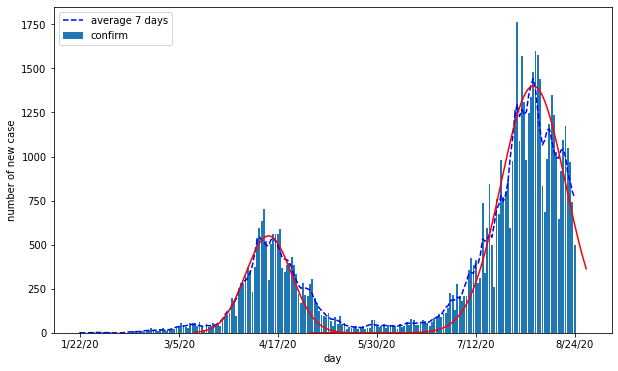

In [9]:
jp_data = [getNewCaseFormCountry(df_confirmed, 'Japan'), getNewCaseFormCountry(df_deaths, 'Japan'), getNewCaseFormCountry(df_recovered, 'Japan')]
days = jp_data[0][1]
x_jp = np.linspace(0, len(days) - 1, len(days))

jp_avg = getAveraged7Days(jp_data[0][0])

plt.figure(figsize = (10, 6))
plt.bar(x_jp, jp_data[0][0], label='confirm')
plt.plot(x_jp, jp_avg, label='average 7 days', color='b', linestyle='dashed')

x_values = np.linspace(50, 150, 1000)
plt.plot(x_values, 550*gaussian(x_values, 82, 10), color='r')
x_values = np.linspace(100, 220, 1000)
plt.plot(x_values, 1400*gaussian(x_values, 197, 14), color='r')
# plt.bar(x_jp, jp_data[2][0], label='recovered')
# plt.bar(x_jp, jp_data[1][0], label='deaths')
plt.xlabel('day')
plt.ylabel('number of new case')
plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

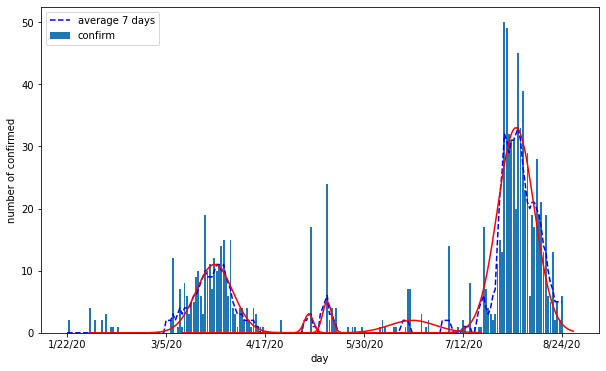

In [10]:
vn_data = [getNewCaseFormCountry(df_confirmed, 'Vietnam'), getNewCaseFormCountry(df_deaths, 'Vietnam'), getNewCaseFormCountry(df_recovered, 'Vietnam')]
days = vn_data[0][1]
x_vn = np.linspace(0, len(days) - 1, len(days))
vn_avg = getAveraged7Days(vn_data[0][0])
plt.figure(figsize = (10, 6))
plt.bar(x_vn, vn_data[0][0], label='confirm')
plt.plot(x_vn, vn_avg, label='average 7 days', color='b', linestyle='dashed')
x_values = np.linspace(10, 100, 1000)
plt.plot(x_values, 11*gaussian(x_values, 64, 8), color='r')

x_values = np.linspace(100, 220, 1000)
plt.plot(x_values, 33*gaussian(x_values, 195, 8), color='r')

x_values = np.linspace(50, 150, 1000)
plt.plot(x_values, 3*gaussian(x_values, 105, 2), color='r')
x_values = np.linspace(50, 150, 1000)
plt.plot(x_values, 5*gaussian(x_values, 113, 2), color='r')
x_values = np.linspace(50, 180, 1000)
plt.plot(x_values, 2*gaussian(x_values, 150, 10), color='r')
# plt.bar(x_vn, vn_data[2][0], label='recovered')
# plt.bar(x_vn, vn_data[1][0], label='deaths')
plt.xlabel('day')
plt.ylabel('number of confirmed')
plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

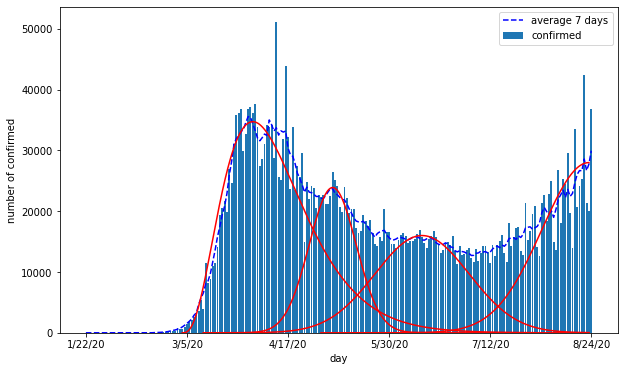

In [11]:

europe_data = [getNewCaseFormContient(df_confirmed, 'Europe'), getNewCaseFormContient(df_deaths, 'Europe'), getNewCaseFormContient(df_recovered, 'Europe')]
days = europe_data[0][1]
x_europe = np.linspace(0, len(days) - 1, len(days))

eu_avg = getAveraged7Days(europe_data[0][0])

plt.figure(figsize = (10, 6))
plt.bar(x_europe, europe_data[0][0], label="confirmed")
plt.plot(x_europe, eu_avg, label='average 7 days', color='b', linestyle='dashed')
x_values = np.linspace(0, 150, 1000)
plt.plot(x_values+41, 1550000*stats.gamma.pdf(x_values, 4, scale = 10), color='r')
x_values = np.linspace(100, 214, 1000)
plt.plot(x_values, 28000*gaussian(x_values, 214, 20), color='r')
x_values = np.linspace(50, 214, 1000)
plt.plot(x_values, 16000*gaussian(x_values, 143, 20), color='r')
x_values = np.linspace(50, 214, 1000)
plt.plot(x_values, 23900*gaussian(x_values, 105, 10), color='r')
# plt.bar(x_europe, europe_data[2][0], label="recoverd")
# plt.bar(x_europe, europe_data[1][0], label="deaths")
plt.xlabel('day')
plt.ylabel('number of confirmed')
plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
plt.show()

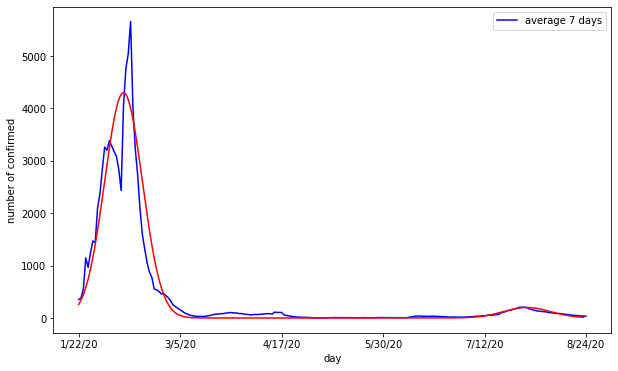

In [12]:
vn_data = [getNewCaseFormCountry(df_confirmed, 'China'), getNewCaseFormCountry(df_deaths, 'China'), getNewCaseFormCountry(df_recovered, 'China')]
days = vn_data[0][1]
x_vn = np.linspace(0, len(days) - 1, len(days))
vn_avg = getAveraged7Days(vn_data[0][0])
plt.figure(figsize = (10, 6))
# plt.bar(x_vn, vn_data[0][0], label='confirm')
plt.plot(x_vn, vn_avg, label='average 7 days', color='b')
x_values = np.linspace(0, 100, 1000)
plt.plot(x_values, 4300*gaussian(x_values, 19, 8), color='r')
x_values = np.linspace(100, 214, 1000)
plt.plot(x_values, 200*gaussian(x_values, 190, 10), color='r')
# x_values = np.linspace(0, 50, 1000)
# plt.plot(x_values, 5700*gaussian(x_values, 22, 3), color='r', label = 'normal')
# plt.bar(x_vn, vn_data[2][0], label='recovered')
# plt.bar(x_vn, vn_data[1][0], label='deaths')
plt.xlabel('day')
plt.ylabel('number of confirmed')
plt.xticks(list(np.arange(0,len(days),int(len(days)/5))),days[:-1:int(len(days)/5)]+[days[-1]])
plt.legend()
# plt.xlim(130, 220)
# plt.ylim(0, 400)
plt.show()

# **4. Training and Evaluation**

## 4.1 Iran


The latest transmission rate beta of SIR model: 0.07654435521630382
The latest recovering rate gamma of SIR model: 0.06907401011518952
The latest basic reproduction number R0: 1.1081498683608577

Confirmed cases tomorrow: 363322.0
Infected persons tomorrow: 29213.0
Recovered + Death persons tomorrow: 334109.0

End day: 21
Confirmed cases on the end day: 402670.0

Turing point: 17


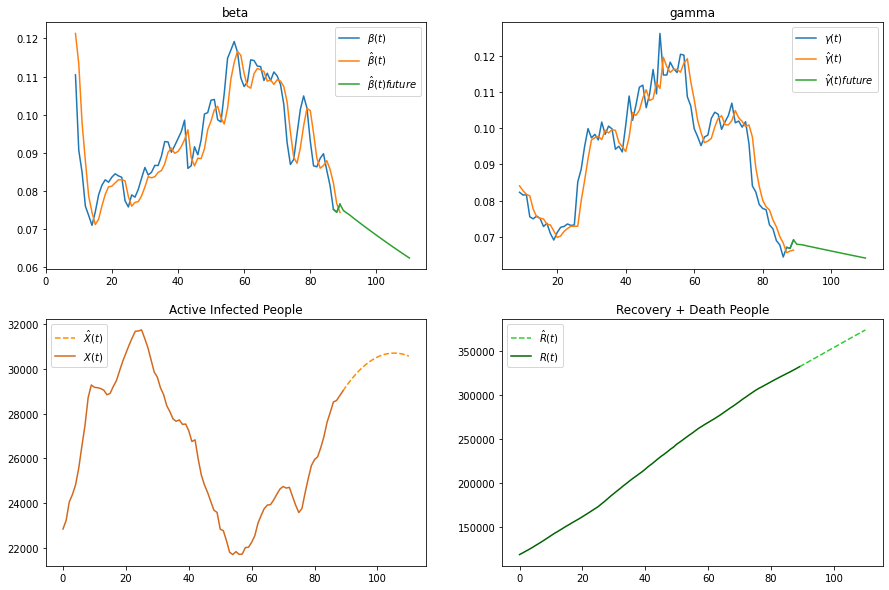

In [13]:
runSIRModel(
    country="Iran",
    population=81.8*100**6,
    num_last_days=90,
    num_future_days=20,
    )

## 4.2 Japan


The latest transmission rate beta of SIR model: 0.04805823003918619
The latest recovering rate gamma of SIR model: 0.06589308491406344
The latest basic reproduction number R0: 0.7293364713742398

Confirmed cases tomorrow: 63859.0
Infected persons tomorrow: 12609.0
Recovered + Death persons tomorrow: 51249.0

End day: 16
Confirmed cases on the end day: 72084.0

Turing point: 0


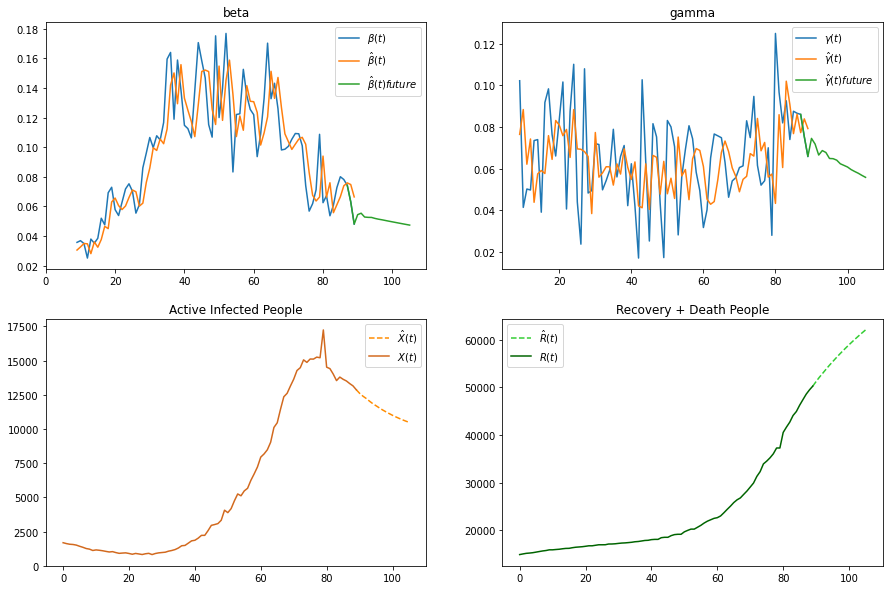

In [14]:
runSIRModel(
    country="Japan",
    population=126.5*100**6,
    num_last_days=90,
    num_future_days=15,
    )

## 4.3 China


The latest transmission rate beta of SIR model: 0.02917020218875134
The latest recovering rate gamma of SIR model: 0.07513261294456407
The latest basic reproduction number R0: 0.38824953699233533

Confirmed cases tomorrow: 89745.0
Infected persons tomorrow: 886.0
Recovered + Death persons tomorrow: 88859.0

End day: 16
Confirmed cases on the end day: 89918.0

Turing point: 0


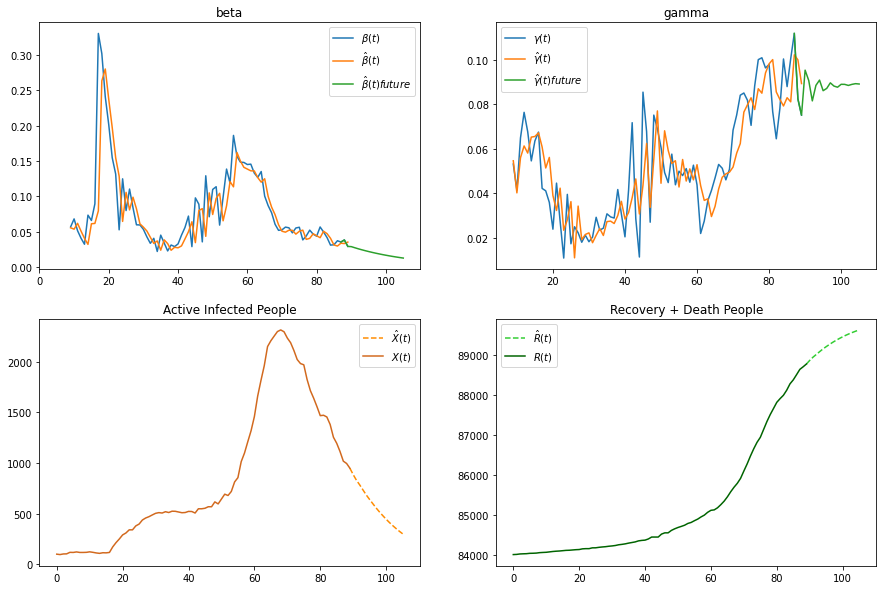

In [15]:
runSIRModel(
    country="China",
    population=1.393*10**9,
    num_last_days=90,
    num_future_days=15,
    )

## 4.4 Vietnam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide



The latest transmission rate beta of SIR model: 0.011563461364853606
The latest recovering rate gamma of SIR model: 0.03561867886474899
The latest basic reproduction number R0: 0.32464599287251233

Confirmed cases tomorrow: 1026.0
Infected persons tomorrow: 401.0
Recovered + Death persons tomorrow: 625.0

End day: 16
Confirmed cases on the end day: 1037.0

Turing point: 0


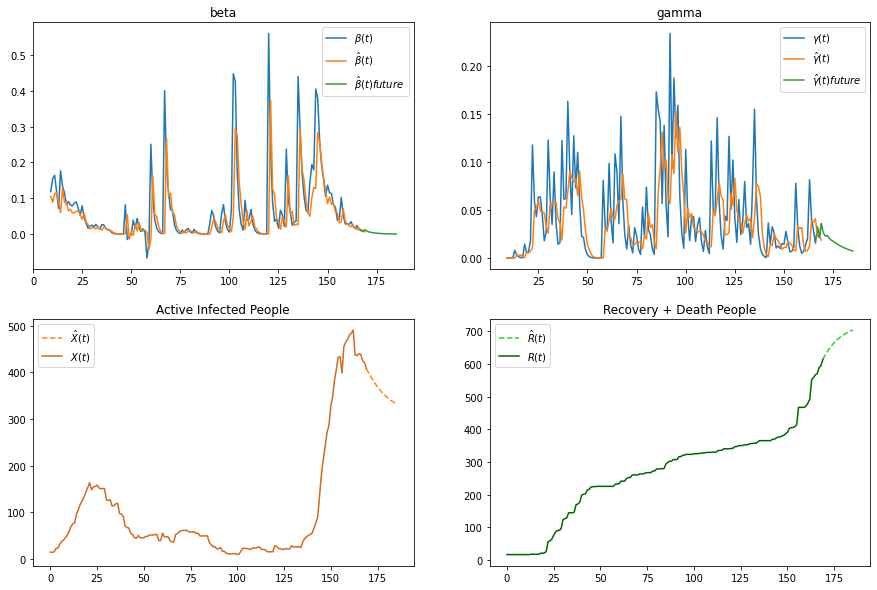

In [16]:
runSIRModel(
    country="Vietnam",
    population=95.54*10**6,
    num_last_days=170,
    num_future_days=15,
    )


The latest transmission rate beta of SIR model: 0.022588093864128904
The latest recovering rate gamma of SIR model: 0.008270685341041261
The latest basic reproduction number R0: 2.7311030383468937

Confirmed cases tomorrow: 3434641.0
Infected persons tomorrow: 1311827.0
Recovered + Death persons tomorrow: 2122814.0

End day: 21
Confirmed cases on the end day: 3853433.0

Turing point: 21


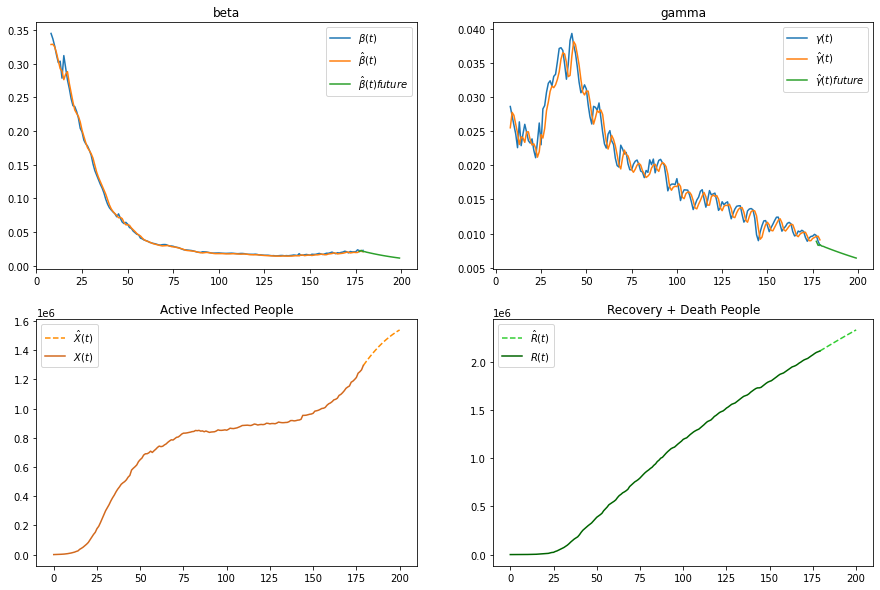

In [17]:
runSIRModel(
    country="Europe",
    population=741.4*10**6,
    num_last_days=180,
    num_future_days=20,
    param_filter=[0.2,0.8],
    param_order=2
    )

# **5. Conclusion**

# Backup

In [18]:
class SIRD:
  def __init__(self):
    self.alpha = [0, 0, 0]


  def predict(self, Nt, q0, alpha=None):
    beta, gamma, mu = self.alpha if alpha is None else alpha
    N = np.sum(q0)

    def sird_ode_equation(t,q):
      S, I, R, D = q
      dS_dt = (-beta*S*I)/N
      dI_dt = (beta*S*I/N) - gamma*I - mu*I
      dR_dt = gamma*I
      dD_dt = mu*I
      return [dS_dt, dI_dt, dR_dt, dD_dt]

    solution = solve_ivp(
                 fun=sird_ode_equation,
                 t_span=[0, Nt],
                 y0=q0,
                 t_eval = np.arange(0, Nt, 1),
                 vectorized=True
               );

    return solution.y

  def solve_dynamic_alpha(self, q0, alpha):
    Nt = alpha.shape[1] - 1
    N = np.sum(q0)

    def sird_ode_equation(t,q):
      beta, gamma, mu = alpha[:, int(t)]

      S, I, R, D = q
      dS_dt = (-beta*S*I)/N
      dI_dt = (beta*S*I/N) - gamma*I - mu*I
      dR_dt = gamma*I
      dD_dt = mu*I
      return [dS_dt, dI_dt, dR_dt, dD_dt]

    solution = solve_ivp(
                 fun=sird_ode_equation,
                 t_span=[0, Nt],
                 y0=q0,
                 t_eval = np.arange(0, Nt, 1),
                 vectorized=True
               );

    return solution.y


  def cost_function(self, alpha, X):
    Nt = X.shape[1]
    q0 = X[:, 0]

    q_predict = self.predict(Nt, q0, alpha)

    J_S = np.sqrt(np.mean((q_predict[0] - X[0])**2))
    J_I = np.sqrt(np.mean((q_predict[1] - X[1])**2))
    J_R = np.sqrt(np.mean((q_predict[2] - X[2])**2))
    J_D = np.sqrt(np.mean((q_predict[3] - X[3])**2))

    J = 0.2*J_S + 0.25*J_I + 0.25*J_R + 0.25*J_D

    return J


  def fit(self, X, alpha0=[0.001, 0.001, 0.001]):
    '''
    Parameter:
      X: is a (4 x Nt) matrix of [Sc, Ic, Rc, Dc]

    Return
      alpha: is the vector of [beta, gamma, mu]
    '''
    optimal = minimize(
                fun=self.cost_function,
                x0=alpha0,
                args=(X),
                method='L-BFGS-B',
                bounds=[(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)]
              )
    
    self.alpha = optimal.x

  def plot():
    pass


The latest transmission rate beta of SIR model: 0.05725839398252093
The latest recovering rate gamma of SIR model: 0.012620698531023638
The latest basic reproduction number R0: 4.536864092092122

Confirmed cases tomorrow: 261364.0
Infected persons tomorrow: 20010.0
Recovered + Death persons tomorrow: 241353.0

End day: 21
Confirmed cases on the end day: 280831.0

Turing point: 21


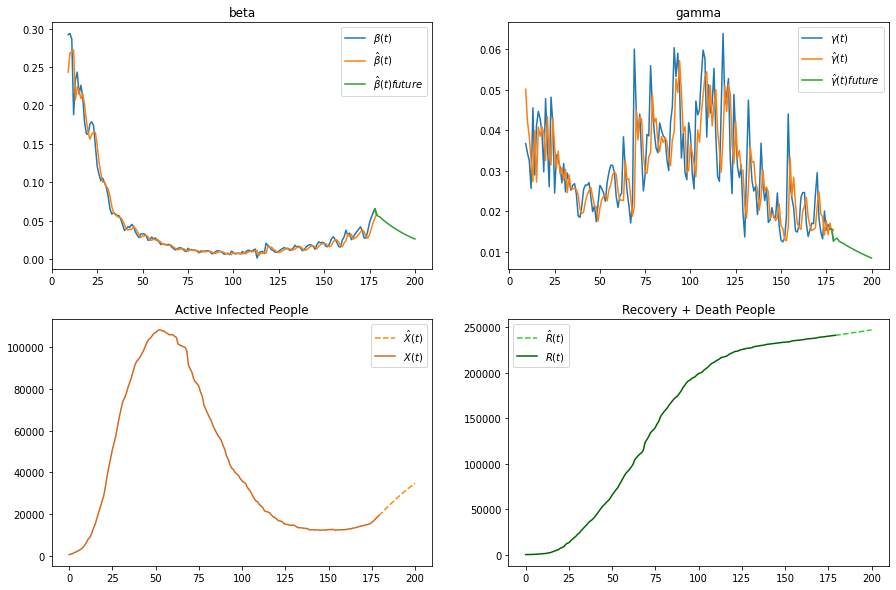

In [19]:
runSIRModel(
    country="Italy",
    population=741.4*10**6,
    num_last_days=180,
    num_future_days=20
    )